In [30]:
import torch
import os
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

# setup (visualization library only supports CPU)
device = torch.device('cpu')

In [34]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.png')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # # Save heatmap on iamge
    # path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    # save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    # path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    # save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial
        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/hen.png', 8),
                    ('input_images/hen_kingsnake_1iters_alexnet.png', 56),
                    ('input_images/hen_kingsnake_4iters_alexnet.png', 56),
                    ('input_images/hen_kingsnake_7iters_alexnet.png', 56),
                    ('input_images/hen_kingsnake_10iters_alexnet.png', 56))
    
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [35]:
import os
import numpy as np

import torch
from torch.optim import SGD
from torchvision import models

class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, starting_image, target_class):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = recreate_image(starting_image)
        # Create the folder to export images if not exists
        if not os.path.exists('../generated/class_'+str(self.target_class)):
            os.makedirs('../generated/class_'+str(self.target_class))

    def generate(self, iterations=150):
        """Generates class specific image
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = 6
        for i in range(1, iterations):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image, False)

            # Define optimizer for the image
            optimizer = SGD([self.processed_image], lr=initial_learning_rate)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i % 10 == 0 or i == iterations-1:
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # if i % 10 == 0 or i == iterations-1:
            #     # Save image
            #     im_path = '../generated/class_'+str(self.target_class)+'/c_'+str(self.target_class)+'_'+'iter_'+str(i)+'.png'
            #     save_image(self.created_image, im_path)

        return self.processed_image

In [36]:
target_example = 0 # hen
(hen_image, hen_tensor, hen_class, file_name_to_export, pretrained_alexnet) = get_example_params(target_example)

# New Section

In [37]:
with torch.no_grad():
  output = pretrained_alexnet(hen_tensor)
torch.argmax(output[0]).item()

7

Iteration: 10 Loss -96.77
150


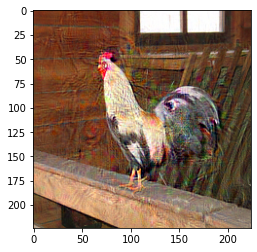

sea_lion
Iteration: 10 Loss -233.41
84


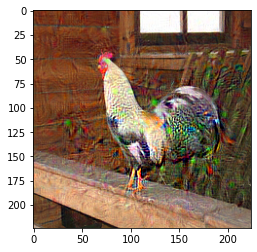

peacock
Iteration: 10 Loss -128.52
340


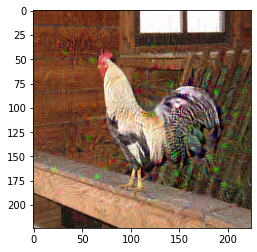

zebra
Iteration: 10 Loss -127.33
417


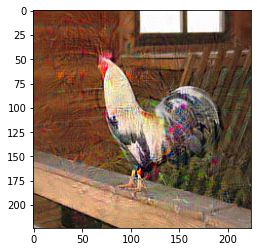

balloon
Iteration: 10 Loss -83.78
947


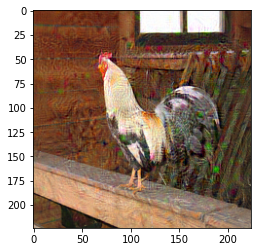

mushroom
	zip warning: name not matched: output_images/

zip error: Nothing to do! (try: zip -r adversarial_images.zip . -i output_images/)


In [38]:
adversarial_classes = [(150, "sea_lion"), (84, "peacock"), (340, "zebra"), (417, "balloon"), (947, "mushroom")]

for adversarial_class, label in adversarial_classes:

# adversarial_class = 56
# label = "kingsnake"

  csig = ClassSpecificImageGeneration(pretrained_alexnet, hen_tensor, adversarial_class)
  output_tensor = csig.generate(iterations = 11)
  with torch.no_grad():
    classification = pretrained_alexnet(output_tensor)

  classification = torch.argmax(classification[0]).item()
  print(classification)

  output_np = recreate_image(output_tensor)
  output_image = Image.fromarray(output_np)
  plt.imshow(output_image)
  plt.show()
  print(label)

  save_image(output_image, "input_images/a_guitar_" + label + "_alexnet.png")

!zip -r adversarial_images.zip output_images/

In [39]:
####### SCORE CAm

In [40]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F




class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class ScoreCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Get convolution outputs
        target = conv_output[0]
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i in range(len(target)):
            # Unsqueeze to 4D
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            # Upsampling to input size
            saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            # Get the target score
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            cam += w.data.numpy() * target[i, :, :].data.numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam


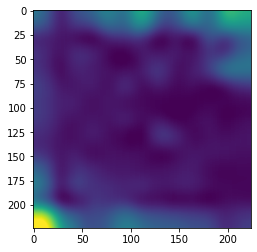

Score cam completed


In [41]:

target_example = 0 # Snake

(original_image, prep_img, target_class, file_name_to_export, pretrained_alexnet) = get_example_params(target_example)
#     # Score cam
score_cam = ScoreCam(pretrained_alexnet, target_layer=11)
#     # Generate cam mask
cam = score_cam.generate_cam(prep_img, target_class = 402)
#     # Save mask

plt.imshow(cam)
plt.show()
save_class_activation_images(original_image, cam,  "_alexnet_a_hen")
print('Score cam completed')





In [17]:
from PIL import Image

im = Image.open('input_images/hen.png')

im1 = im.resize((224, 224))
im1.save('input_images/hen__1.png')


In [ ]:
pretrained_vgg = models.vgg16(pretrained=True)
pretrained_vgg



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

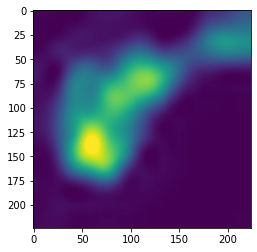

Score cam completed


In [ ]:
target_example = 0 # Snake

(original_image, prep_img, target_class, file_name_to_export, pretrained_vgg) = get_example_params(target_example)
#     # Score cam
score_cam = ScoreCam(pretrained_vgg, target_layer=11)
#     # Generate cam mask
cam = score_cam.generate_cam(prep_img, target_class = 402)
#     # Save mask

plt.imshow(cam)
plt.show()
save_class_activation_images(original_image, cam,  "_vgg_a_guitar_class")
print('Score cam completed')



# New Section